# ABS Tutorial 07

## template fitting mock data test (simple likelihood, T mode, non-parametric CMB)

The `simple likelihood` is designed for pipeline's sanity check:

$$ \mathcal{L} =  - 0.5 \left( X^T \mathcal{M}^{-1}_{cc'} X \right) $$

$$ X = D - \hat{D} $$

where X is the vectorized cross-power-spectrum which contains band-power from each `frequency` and `multipole bin`, the covariance matrix is approximated by noise re-sampling.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gsp
import afra as af
from afra.tools.ps_estimator import pstimator
from afra.tools.fg_models import syncmodel, dustmodel, syncdustmodel
from afra.tools.bg_models import cmbmodel
from afra.tools.aux import vec_simple
from afra.methods.tpfit import tpfit_simple
import seaborn as sns
from dynesty import plotting as dyplot
import warnings
warnings.filterwarnings('ignore')

### read maps

In [2]:
NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True)
map30 = hp.smoothing(map30f+mapcmb,fwhm=fwhm[0])
map95 = hp.smoothing(map95f+mapcmb,fwhm=fwhm[1])
map150 = hp.smoothing(map150f+mapcmb,fwhm=fwhm[2])
map353 = hp.smoothing(map353f+mapcmb,fwhm=fwhm[3])

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 12.739827 arcmin (0.003706 rad) 
-> fwhm is 30.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 7.643896 arcmin (0.002224 rad) 
-> fwhm is 18.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 5.095931 arcmin (0.001482 rad) 
-> fwhm is 12.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.038372 arcmin (0.000593 rad) 
-> fwhm is 4.800000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### 1st run with sync model

- mock data frequencies: 30, 95, 150
- template frequency: 30
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw

fg truths:  {'beta_s': -3.0}
cmb truths:  {'bp_c_T_121.5': 3218.4613274339995, 'bp_c_T_201.5': 5277.511842185023}
CPU times: user 2min 27s, sys: 693 ms, total: 2min 27s
Wall time: 37.2 s


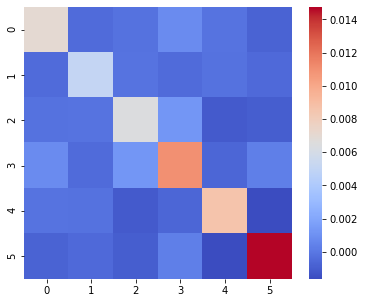

In [3]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)

s = syncmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
s.reset({'beta_s': -3.})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',s.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(s.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
3
parameters
dict_keys(['bp_c_T_121.5', 'bp_c_T_201.5', 'beta_s'])
parameter range
{'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_s': [-5.0, 0.0]}




iter: 23036 | +1000 | bound: 33 | nc: 1 | ncall: 84355 | eff(%): 28.494 | loglstar:   -inf < -0.003 <    inf | logz: -22.779 +/-  0.208 | dlogz:  0.001 >  1.009                                      

CPU times: user 1min 49s, sys: 11.6 s, total: 2min 1s
Wall time: 1min 51s


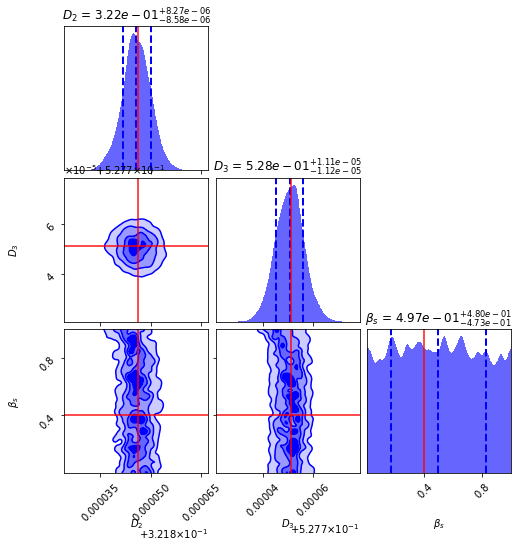

In [4]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,s)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1][1:]/1.e+4) + [(5.-3.)/5.]
labels = [r'$D_2$',r'$D_3$',r'$\beta_s$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 2nd run with dust model

- mock data frequencies: 95, 150, 353
- template frequency: 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated modified blackbody

fg truths:  {'beta_d': 1.5}
cmb truths:  {'bp_c_T_121.5': 3218.4613274339995, 'bp_c_T_201.5': 5277.511842185023}
CPU times: user 2min 12s, sys: 677 ms, total: 2min 13s
Wall time: 33.9 s


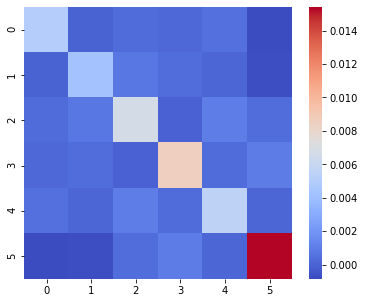

In [5]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 30
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[353] = map353f[0].reshape(1,-1)

d = dustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
              templates=tmpmap,template_fwhms=None)
d.reset({'beta_d':1.5})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',d.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(d.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
3
parameters
dict_keys(['bp_c_T_121.5', 'bp_c_T_201.5', 'beta_d'])
parameter range
{'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_d': [0.0, 5.0]}




iter: 28709 | +1000 | bound: 48 | nc: 1 | ncall: 106586 | eff(%): 27.873 | loglstar:   -inf < -0.007 <    inf | logz: -28.601 +/-  0.241 | dlogz:  0.001 >  1.009                                     

CPU times: user 2min 37s, sys: 16.1 s, total: 2min 53s
Wall time: 2min 39s


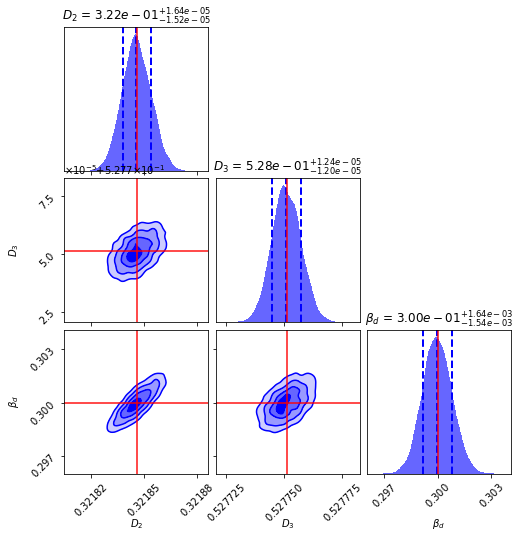

In [6]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,d)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1][1:]/1.e+4) + [1.5/5.]
labels = [r'$D_2$',r'$D_3$',r'$\beta_d$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

### 3rd run with sync+dust model

- mock data frequencies: 30, 95, 150, 353
- template frequency: 30, 353
- multipole bin-width: 80
- mask: Ali
- apodization: True, 6 deg
- map variances: Plk, Ali
- foreground model: templated powerlaw and templated modified blackbody

fg truths:  {'beta_s': -3.0, 'beta_d': 1.5, 'rho': 0.0}
cmb truths:  {'bp_c_T_121.5': 3218.4613274339995, 'bp_c_T_201.5': 5277.511842185023}
CPU times: user 2min 55s, sys: 660 ms, total: 2min 55s
Wall time: 44.7 s


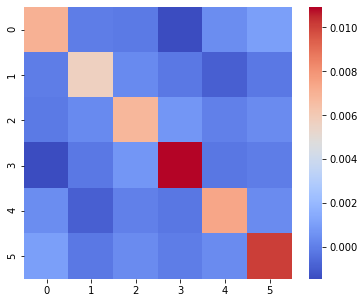

In [7]:
%%time

FREQS = [95.,150.]
NMAP = 1
RESAMP = 40
APOSCALE = 6.
PSBIN = 80

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam)
mock_cov = pipeline.preprocess_simple(aposcale=APOSCALE,psbin=PSBIN,nsamp=RESAMP)[1]

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(mock_cov,cmap='coolwarm',annot=False,ax=ax)

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)
tmpmap[353] = map353f[0].reshape(1,-1)

c = syncdustmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,
                  templates=tmpmap,template_fwhms=None)
c.reset({'beta_s':-3.})
c.reset({'beta_d':1.5})

b = cmbmodel(freqs=FREQS,nmap=NMAP,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)

# update CMB band powers by realistic values
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN)
auto_cmb_t = est.auto_t(mapcmb[0].reshape(1,-1))
for i in range(len(auto_cmb_t[0])):
    name = 'bp_c_T_'+str(auto_cmb_t[0][i])
    b.reset({name: auto_cmb_t[1][i]})
    
print ('fg truths: ',c.params)
print ('cmb truths: ',b.params)

mock_bp = vec_simple(c.bandpower()+b.bandpower())


 template fitting kernel check list 

# of parameters
5
parameters
dict_keys(['bp_c_T_121.5', 'bp_c_T_201.5', 'beta_s', 'beta_d', 'rho'])
parameter range
{'bp_c_T_121.5': [0.0, 10000.0], 'bp_c_T_201.5': [0.0, 10000.0], 'beta_s': [-5.0, 0.0], 'beta_d': [0.0, 5.0], 'rho': [-1.0, 1.0]}




iter: 28983 | +1000 | bound: 62 | nc: 1 | ncall: 128355 | eff(%): 23.359 | loglstar:   -inf < -0.018 <    inf | logz: -28.906 +/-  0.244 | dlogz:  0.001 >  1.009                                     

CPU times: user 4min 31s, sys: 24.5 s, total: 4min 56s
Wall time: 4min 31s


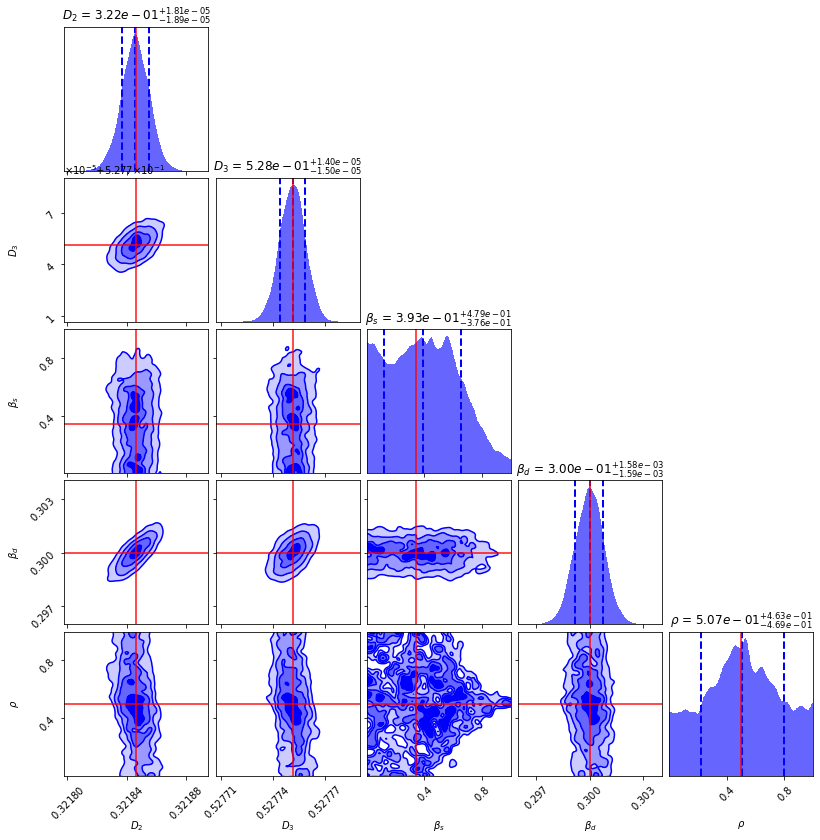

In [8]:
%%time

engine = tpfit_simple(mock_bp,mock_cov,b,c)

KWARGS = {'nlive':1000}
result = engine(kwargs=KWARGS)

truths = list(auto_cmb_t[1][1:]/1.e+4) + [(5.-3.3)/5.,1.5/5.,0.5]
labels = [r'$D_2$',r'$D_3$',r'$\beta_s$',r'$\beta_d$',r'$\rho$']

fg, ax = dyplot.cornerplot(result, color='blue', truths=truths,
                           labels=labels, use_math_text=True,
                           truth_color='red', show_titles=True,title_fmt='.2e',
                           max_n_ticks=3, quantiles=[0.16,0.5,0.84])

end